In [2]:
# followed this tutorial https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt

cudnn.benchmark = True
plt.ion()   # interactive mode


In [3]:
data_transforms = {
    'train': transforms.Compose([   
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [4]:
data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                          data_transforms[x]) for x in ['train', 'val']} 
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                               batch_size=4, shuffle=True, num_workers=4) 
                                               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

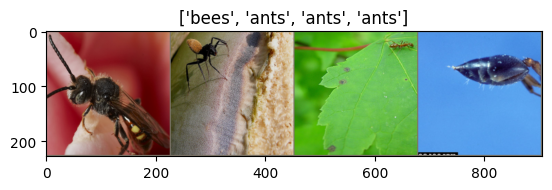

In [7]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
inputs, classes = next(iter(data_loaders["train"]))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [15]:
def train_model(model, criterion, optimizer, sheduler, num_epochs=25):
    since = time.time()
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir,  'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        for epoch in range(num_epochs):
            print("Epoch{epoch}/{num_epochs-1}")
            print("-" * 10) 
            for phase in ["train", "val"]:
                if phase == "train":
                    model.train()
                else:
                    model.eval()
                running_loss = 0.0
                running_corrects = 0
                for inputs, labels in data_loaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        if phase == "train":
                            loss.backward()
                            optimizer.step()
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == "train":
                    sheduler.step()
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
                if phase == "val" and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

                print()
        time_elapsed = time.time() - since
        print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [1]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(f"predicted: {class_names[preds[j]]}")

                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jk/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, 
                              exp_lr_scheduler, num_epochs=25)


Epoch{epoch}/{num_epochs-1}
----------
train Loss: 0.3353 Acc: 0.8525

val Loss: 0.2823 Acc: 0.9020

Epoch{epoch}/{num_epochs-1}
----------
train Loss: 0.3492 Acc: 0.8484

val Loss: 0.2791 Acc: 0.8889

Epoch{epoch}/{num_epochs-1}
----------
train Loss: 0.3528 Acc: 0.8443

val Loss: 0.2882 Acc: 0.8889

Epoch{epoch}/{num_epochs-1}
----------
train Loss: 0.2738 Acc: 0.8689

val Loss: 0.2871 Acc: 0.8889

Epoch{epoch}/{num_epochs-1}
----------
train Loss: 0.3113 Acc: 0.8525

val Loss: 0.3080 Acc: 0.8954

Epoch{epoch}/{num_epochs-1}
----------
train Loss: 0.2735 Acc: 0.8811

val Loss: 0.2771 Acc: 0.8954

Epoch{epoch}/{num_epochs-1}
----------
train Loss: 0.2790 Acc: 0.8852

val Loss: 0.3521 Acc: 0.8693

Epoch{epoch}/{num_epochs-1}
----------
train Loss: 0.3014 Acc: 0.8648

val Loss: 0.2919 Acc: 0.8954

Epoch{epoch}/{num_epochs-1}
----------
train Loss: 0.3302 Acc: 0.8525

val Loss: 0.2788 Acc: 0.8954

Epoch{epoch}/{num_epochs-1}
----------
train Loss: 0.2638 Acc: 0.8934

val Loss: 0.2921 Acc

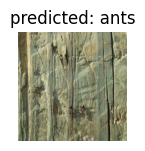

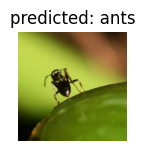

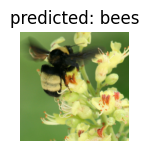

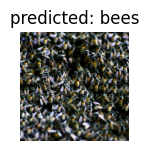

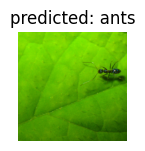

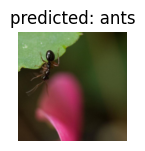

In [17]:
visualize_model(model_ft)